In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-e4n4pun4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-e4n4pun4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from segment_anything import SamPredictor, sam_model_registry

from PIL import Image

import sys
sys.path.append("../")

from lynx_id.data.dataset import LynxDataset
from pathlib import Path

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/gpfs7kro/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/torchvision-0.15.2a0+fa99a53-py3.10-linux-x86_64.egg/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

(811, 1227, 3) 0.916


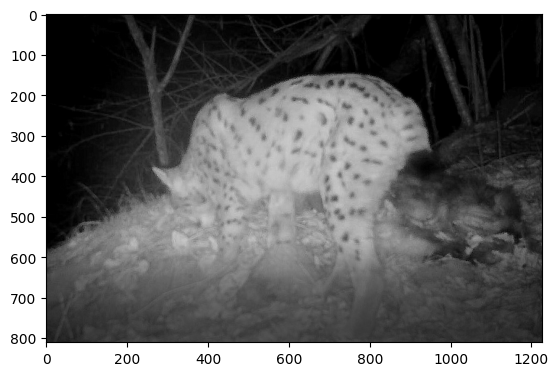

Exception ignored in atexit callback: <bound method InteractiveShell.atexit_operations of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7ff8a8d77eb0>>
Traceback (most recent call last):
  File "/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3875, in atexit_operations
    self._atexit_once()
  File "/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3858, in _atexit_once
    self.history_manager.end_session()
  File "/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/IPython/core/history.py", line 579, in end_session
    self.writeout_cache()
  File "/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/gpfslocalsup/p

In [23]:
lynxDataset = LynxDataset(Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv"))

idx = 0

image = lynxDataset[idx][0]['image']
conf = lynxDataset[idx][0]['conf']
x = lynxDataset[idx][0]['x']
y = lynxDataset[idx][0]['y']
width = lynxDataset[idx][0]['width']
height = lynxDataset[idx][0]['height']
plt.imshow(image)

print(image.shape, conf)

In [5]:
sam = sam_model_registry["vit_b"](checkpoint="./segment_anything/sam_vit_b_01ec64.pth")
predictor = SamPredictor(sam)

In [6]:
predictor.set_image(image)

In [7]:
input_box = np.array([x, y, x+width, y+height])

In [8]:
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [9]:
print(masks.shape, scores.shape, logits.shape)

(1, 2592, 3456) (1,) (1, 256, 256)


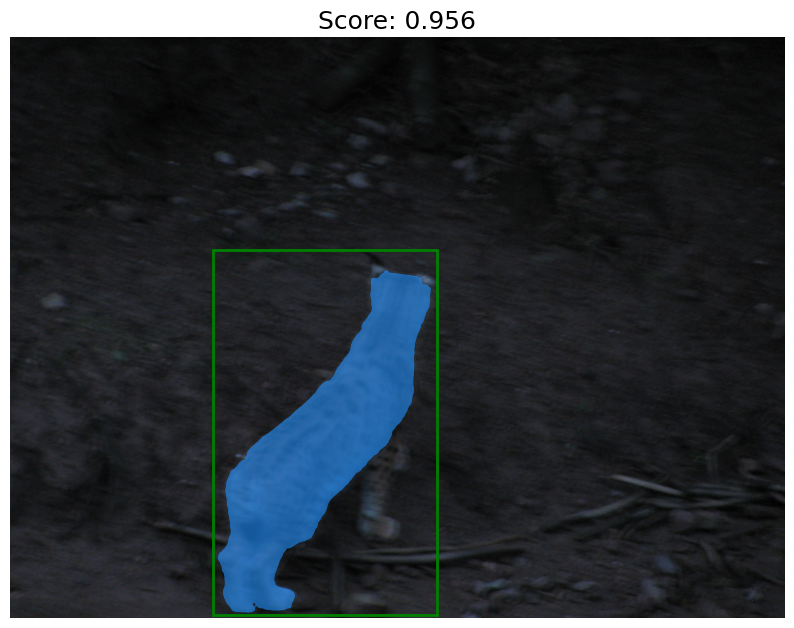

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.title(f"Score: {scores[0]:.3f}", fontsize=18)
plt.axis('off')
plt.show()

In [11]:
mask = masks[0]

In [12]:
image_masque = image.copy()
image_masque[~mask, :] = 0
image_masque = image_masque[int(y):int(y)+int(height), int(x):int(x)+int(width), :]

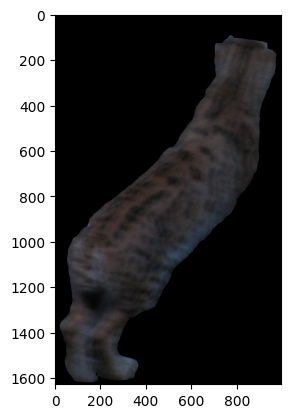

In [13]:
plt.imshow(image_masque)